# Imports 

In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

# Full dataset
Load gridtx-dump

In [126]:
# Load gridtx dump 
dtype={'adjusts_id': 'object',
       'ediel_product_code': 'float64',
       'invoice_item_id': 'object',
       'parent_id': 'object',
       'meter_id': 'object'}

file = "data/gridtx-dump.csv"
df = dd.read_csv(file, sep=";", dtype=dtype)

Explore gridtx dump

In [131]:
# Get uniqe meter ids 
meter_ids = df["meter_id"].unique().compute()
len(meter_ids)

1969

In [48]:
# Get number of rows in dataframe
num_rows = len(df)
num_rows

40075583

In [50]:
# Number of unique rows in dataset
unique_rows = len(df.drop_duplicates())
unique_rows


In [46]:
# Check if timeslot is uniqe
timeslot_unique_count = df[["timeslot","meter_id", "type"]].drop_duplicates().shape[0].compute()
timeslot_unique_count

24440788

In [3]:
# Descibe data 
df.describe().compute()

,num_kwh,spot_price_no_vat,amount_no_vat,amount_with_vat,vat_percent,ediel_product_code,kwh_fee_no_vat
count,4.007558e+07,4.002075e+07,4.007558e+07,4.007558e+07,4.007558e+07,3.997582e+07,4.007558e+07
mean,1.261181e+00,-1.191252e-01,1.322791e-03,1.862953e-03,1.670095e+01,1.491748e+03,1.492465e-02
std,5.996560e+00,6.360822e-01,2.223072e+01,2.746402e+01,1.177294e+01,8.819701e+00,2.259279e-02
min,-1.560000e+03,-1.116000e+00,-9.646320e+03,-1.205790e+04,0.000000e+00,1.481000e+03,0.000000e+00
25%,0.000000e+00,2.000000e-02,0.000000e+00,0.000000e+00,2.500000e+01,1.491000e+03,0.000000e+00
50%,0.000000e+00,3.722800e-01,0.000000e+00,0.000000e+00,2.500000e+01,1.491000e+03,0.000000e+00
75%,2.047500e+00,5.370600e-01,1.261000e+00,1.577000e+00,2.500000e+01,1.491000e+03,5.600000e-02
max,2.347000e+03,2.454310e+00,6.255580e+03,7.819480e+03,2.500000e+01,1.591000e+03,5.600000e-02


In [3]:
meter_row_counts = df["meter_id"].value_counts().compute()

# New metering-point data
Creates a new metering-point dataset so we only include meters that are in our gridtx dataset

In [132]:
meters = pd.read_csv("data/grid-metering-point-dump-plus-zipcode-GMAPS.csv")
print("Number of rows in meters dataset: ", str(len(meters)))
new_meters = meters[meters.idgrid_data_table.isin(meter_ids)]
print("Number of rows in new meters dataset: ", str(len(new_meters)))

Number of rows in meters dataset:  2049
Number of rows in new meters dataset:  1968


In [41]:
new_meters.to_csv("data/grid-metering-point-dump-plus-zipcode-GMAPS-in-gridtx.csv")

# Explore meters
Explore the newly created dataset

In [133]:
# Load data
new_meters = pd.read_csv("data/grid-metering-point-dump-plus-zipcode-GMAPS-in-gridtx.csv")

new_meters = new_meters[['idgrid_data_table', 'created_atgrid_data_table',
       'updated_atgrid_data_table', 'meter_number', 'ean', 'automatic_meter',
       'street_address', 'grid_owner_id', 'metering_grid_area', 'zip_code_id',
       'provider', 'settlement_method', 'market_balance_area', 'code', 'name',
       'idzipcode_table', 'created_atzipcode_table', 'updated_atzipcode_table',
       'country', 'full_address', 'lat', 'lng']]


In [196]:
NO1_meters = list(new_meters[new_meters["market_balance_area"] == "NO1"]["idgrid_data_table"])
NO2_meters = list(new_meters[new_meters["market_balance_area"] == "NO2"]["idgrid_data_table"])
NO3_meters = list(new_meters[new_meters["market_balance_area"] == "NO3"]["idgrid_data_table"])
NO4_meters = list(new_meters[new_meters["market_balance_area"] == "NO4"]["idgrid_data_table"])
NO5_meters = list(new_meters[new_meters["market_balance_area"] == "NO5"]["idgrid_data_table"])

# print(new_meters["market_balance_area"].value_counts().to_latex())

In [219]:
# Count automatic meters 
print(new_meters["automatic_meter"].value_counts())

non_automatic_meters = list(new_meters[new_meters["automatic_meter"] == "f"]["idgrid_data_table"])
automatic_meters = list(new_meters[new_meters["automatic_meter"] == "t"]["idgrid_data_table"])


# Describe observation amount of non-automatic meters 
# print("Describe non-automatic meters count:")
# print(meter_row_counts[non_automatic_meters].describe())
# print("Describe automatic meters count:")
# print(meter_row_counts[automatic_meters])

t    1907
f      61
Name: automatic_meter, dtype: int64


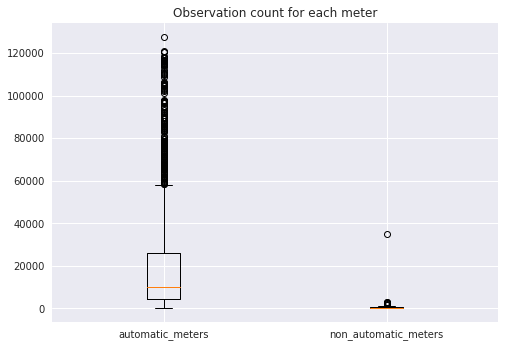

In [215]:
with plt.style.context("seaborn"):
    plt.boxplot([meter_row_counts[automatic_meters], meter_row_counts[non_automatic_meters]])
    plt.title("Observation count for each meter")
    plt.xticks([1, 2], ['automatic_meters', 'non_automatic_meters'])


In [160]:

# Get hourly meters by code 
# hourly_meter_codes = [1491, 1481]
hourly_meters = new_meters[(new_meters["code"] == 1491) | (new_meters["code"] == 1481)]
daily_meters = new_meters[(new_meters["code"] == 1591) | (new_meters["code"] == 1581)]

print(f"There are {len(hourly_meters)} hourly meters")
print(f"There are {len(daily_meters)} daily meters")

There are 7 hourly meters
There are 0 daily meters


In [83]:
new_meters[new_meters["automatic_meter"] == "f"]["market_balance_area"].value_counts()


NO1    50
NO2     7
NO5     3
NO3     1
Name: market_balance_area, dtype: int64

In [162]:
Z32_meters = list(new_meters[new_meters["settlement_method"] == "Z32"]["idgrid_data_table"])
Z31_meters = list(new_meters[new_meters["settlement_method"] == "Z31"]["idgrid_data_table"])

new_meters["settlement_method"].value_counts()

Z32    1821
Z31     147
Name: settlement_method, dtype: int64

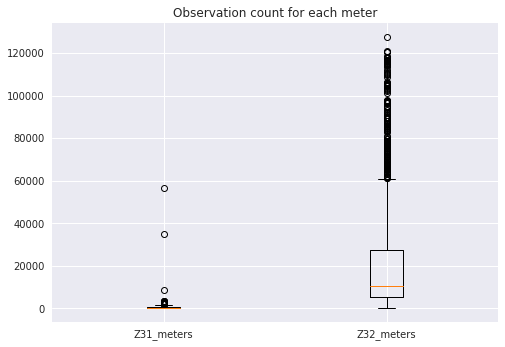

In [216]:
with plt.style.context("seaborn"):
    plt.boxplot([meter_row_counts[Z31_meters], meter_row_counts[Z32_meters]])
    plt.title("Observation count for each meter")
    plt.xticks([1, 2], ['Z31_meters', 'Z32_meters'])

In [228]:
# Check the settlement method for the non_automatic meters 
new_meters[new_meters["idgrid_data_table"].isin(non_automatic_meters)]["settlement_method"].value_counts()



Z31    61
Name: settlement_method, dtype: int64

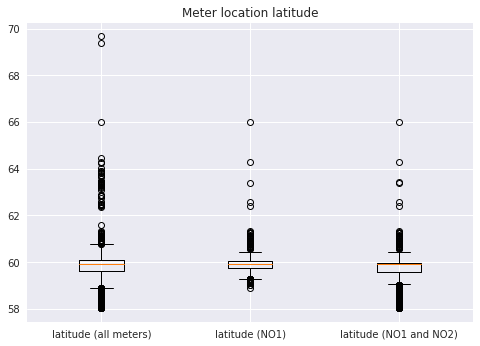

In [267]:
with plt.style.context("seaborn"):
    plt.boxplot([ new_meters["lat"], new_meters[new_meters["idgrid_data_table"].isin(NO1_meters)]["lat"], new_meters[(new_meters["idgrid_data_table"].isin(NO1_meters)) | (new_meters["idgrid_data_table"].isin(NO2_meters))]["lat"] ])
    plt.title("Meter location latitude")
    plt.xticks([1, 2, 3], ['latitude (all meters)', 'latitude (NO1)', 'latitude (NO1 and NO2)'])


In [ ]:
ids_to_keep = list(new_meters["idgrid_data_table"])

updated_meter_ids = [id for id in ids_to_keep if id not in non_automatic_meters]
updated_meter_ids = [id for id in updated_meter_ids if id not in Z31_meters]
updated_meter_ids = [id for id in updated_meter_ids if id in NO1_meters]

print(f"{len(updated_meter_ids)} meters in the updated dataset")

1456 meters in the updated dataset


In [ ]:
# hourly_meter_ids = list(new_meters[(new_meters["code"] < 1500) & (new_meters["code"] >= 1400)]["idgrid_data_table"])
# daily_meter_ids = list(new_meters[(new_meters["code"] < 1600) & (new_meters["code"] >= 1500)]["idgrid_data_table"])

98

In [ ]:
meter_row_counts[hourly_meter_ids].describe()

count        98.000000
mean      27129.469388
std       29106.730007
min          12.000000
25%        3032.500000
50%       15980.000000
75%       45153.250000
max      116491.000000
Name: meter_id, dtype: float64

In [ ]:
meter_row_counts[daily_meter_ids].describe()

count       117.000000
mean      10966.572650
std       14983.078372
min          17.000000
25%        2849.000000
50%        7039.000000
75%       10216.000000
max      105251.000000
Name: meter_id, dtype: float64

In [ ]:
datata = pd.read_csv("data/3ba47f27-33e8-4764-a390-d33ca37d625f.csv")

datata.head()

,id,created_at,updated_at,num_kwh,timeslot,type,estimation,spot_price_no_vat,amount_no_vat,adjusts_id,parent_id,vat_percent,meter_id,kwh_fee_no_vat
0,5aa2b892-d0eb-4c9d-97c0-460d3a94fea9,2017-12-22 05:29:21.359837+01,2017-12-22 05:29:21.359837+01,3.0,2017-12-13 02:00:00+01,elcert,f,0.020,0.06,NaN,3d6248ef-7055-463d-ba6b-db02072b976a,25,3ba47f27-33e8-4764-a390-d33ca37d625f,0.0
1,2b74be2c-4cc9-4c55-a5bb-f53b9365fb6c,2017-12-22 05:29:23.71587+01,2017-12-22 05:29:23.71587+01,0.0,2017-12-12 17:00:00+01,production,f,-1.000,0.00,4cad8e91-31f5-48a7-8f46-4438fe9883bf,52c6d1fd-16a7-4a18-8078-f1ae4575aba4,0,3ba47f27-33e8-4764-a390-d33ca37d625f,0.0
2,9afa70a4-b11e-4c32-93b0-ed83af9311a9,2017-12-22 05:29:23.799782+01,2017-12-22 05:29:23.799782+01,0.0,2017-12-12 16:00:00+01,production,f,-1.000,0.00,NaN,NaN,0,3ba47f27-33e8-4764-a390-d33ca37d625f,0.0
3,e1e0751e-16e6-4b31-9e66-c4a16ecb1cab,2017-12-22 05:29:26.089094+01,2017-12-22 05:29:26.089094+01,0.0,2017-12-12 08:00:00+01,production,f,-1.000,0.00,51e84716-3a8a-460a-8d46-d0f6b316c169,8f3ec39a-f394-4dca-9036-00054b061cec,0,3ba47f27-33e8-4764-a390-d33ca37d625f,0.0
4,dbdc1d94-05bf-4567-a3a8-0f7c1d8c8bf3,2017-12-22 05:29:30.795343+01,2017-12-22 05:29:30.795343+01,0.0,2017-12-11 14:00:00+01,consumption,f,0.519,0.00,ec1a3474-2178-432d-9d4c-947d09b23706,3992ce36-3fc7-4770-b4f1-315fdb109a58,25,3ba47f27-33e8-4764-a390-d33ca37d625f,0.0


# Explore Merged Meter Ids

In [ ]:
# Load data 
dtype={'adjusts_id': 'object',
       'ediel_product_code': 'float64',
       'invoice_item_id': 'object',
       'parent_id': 'object',
       'meter_id': 'str'}

file = "data/merged_meter_ids.csv"
df = dd.read_csv(file, sep=";", dtype=dtype)

In [ ]:
print(list(df.columns))
print(df.head())

['Unnamed: 0', 'created_at', 'updated_at', 'num_kwh', 'timeslot', 'type', 'estimation', 'spot_price_no_vat', 'amount_no_vat', 'vat_percent', 'meter_id', 'kwh_fee_no_vat']
   Unnamed: 0                     created_at                     updated_at  \
0           0  2018-04-26 16:34:10.145628+02  2018-04-26 16:34:10.145628+02   
1           1  2018-04-25 06:11:19.555649+02  2018-04-26 16:34:10.192034+02   
2           2   2018-04-26 16:34:10.25942+02   2018-04-26 16:34:10.25942+02   
3           3  2018-04-25 06:11:19.741357+02  2018-04-26 16:34:10.508598+02   
4           4  2018-04-26 16:34:10.596066+02  2018-04-26 16:34:10.596066+02   

   num_kwh                timeslot        type estimation  spot_price_no_vat  \
0      3.0  2018-04-22 23:00:00+02      elcert          f               0.02   
1      0.0  2018-04-22 23:00:00+02  production          f              -1.00   
2      0.0  2018-04-22 23:00:00+02  production          f              -1.00   
3      0.0  2018-04-22 22:00:00+02

In [ ]:
print(df["vat_percent"].unique().compute())


0    25
1     0
Name: vat_percent, dtype: int64


In [ ]:
print(df["vat_percent"].unique().compute())


print(df["estimation"].unique().compute())



0    25
1     0
Name: vat_percent, dtype: int64
0    f
1    t
Name: estimation, dtype: object


In [ ]:
# Load data 
dtype={'adjusts_id': 'object',
       'ediel_product_code': 'float64',
       'invoice_item_id': 'object',
       'parent_id': 'object',
       'meter_id': 'str'}

file = "data/merged_meter_ids-MERGED.csv"
df = dd.read_csv(file, sep=";", dtype=dtype)

In [ ]:
list(df.columns)

['Unnamed: 0,created_at,updated_at,num_kwh,timeslot,type,estimation,spot_price_no_vat,amount_no_vat,vat_percent,meter_id,kwh_fee_no_vat,idgrid_data_table,automatic_meter,market_balance_area,code,lat,lng']

In [ ]:
df.

,"Unnamed: 0,created_at,updated_at,num_kwh,timeslot,type,estimation,spot_price_no_vat,amount_no_vat,vat_percent,meter_id,kwh_fee_no_vat,idgrid_data_table,automatic_meter,market_balance_area,lat,lng"
unique,5843450
count,5843450
top,"0,2018-04-26 16:34:10.145628+02,2018-04-26 16:..."
freq,1


In [ ]:
file  = "data/grid-metering-point-dump-plus-zipcode-GMAPS-in-gridtx.csv"
df = pd.read_csv(file)

In [ ]:
df["automatic_meter"].value_count()

AttributeError: 'Series' object has no attribute 'value_count'

In [ ]:
df["automatic_meter"].values_count()

AttributeError: 'Series' object has no attribute 'values_count'

# Random meter IDs

In [2]:
file = "data/random-meter-ids.csv"
df = pd.read_csv(file, sep=";")

C:\Users\andre\AppData\Local\Temp\ipykernel_20120\1218862467.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep=";")


In [3]:
# print(df[["meter_id","timeslot"]].value_counts())


# df[(df["meter_id"] == "d63b305d-7049-4c56-b121-48478c7dfbb1") & (df["timeslot"] == "2018-06-30 00:00:00+02")]


df[df["num_kwh"] == 0.0]["amount_no_vat"].describe()


df[(df["num_kwh"] == 0.0) & (df["type"] == "consumption")].describe()

print("Consumption (num_kwh) below 0: {}".format(df[(df["type"] == "consumption") & (df["num_kwh"] < 0)].shape[0]))
print("Consumption (num_kwh) equal to 0: {}".format(df[(df["type"] == "consumption") & (df["num_kwh"] == 0)].shape[0]))
print("Consumption (num_kwh) above 0: {}".format(df[(df["type"] == "consumption") & (df["num_kwh"] > 0)].shape[0]))
print()
print("Production (num_kwh) below 0: {}".format(df[(df["type"] == "production") & (df["num_kwh"] < 0)].shape[0]))
print("Production (num_kwh) equal to 0: {}".format(df[(df["type"] == "production") & (df["num_kwh"] == 0)].shape[0]))
print("Production (num_kwh) above 0: {}".format(df[(df["type"] == "production") & (df["num_kwh"] > 0)].shape[0]))
print()
print("Elcert (num_kwh) below 0: {}".format(df[(df["type"] == "elcert") & (df["num_kwh"] < 0)].shape[0]))
print("Elcert (num_kwh) equal to 0: {}".format(df[(df["type"] == "elcert") & (df["num_kwh"] == 0)].shape[0]))
print("Elcert (num_kwh) above 0: {}".format(df[(df["type"] == "elcert") & (df["num_kwh"] > 0)].shape[0]))


Consumption (num_kwh) below 0: 8029
Consumption (num_kwh) equal to 0: 142933
Consumption (num_kwh) above 0: 172661

Production (num_kwh) below 0: 8020
Production (num_kwh) equal to 0: 219298
Production (num_kwh) above 0: 19011

Elcert (num_kwh) below 0: 2092
Elcert (num_kwh) equal to 0: 63323
Elcert (num_kwh) above 0: 59267


In [26]:
type_sum = df.groupby(["meter_id", "type"], as_index=False).sum()

type_sum.shape[0]

type_sum["num_kwh"].describe()

# df[["meter_id", "type"]].drop_duplicates().shape[0]
# type_sum = df.group_by("meter_id")

0              consumption
1                   elcert
2      payment_consumption
3           payment_elcert
4              consumption
              ...         
129    payment_consumption
130            consumption
131    payment_consumption
132     payment_production
133             production
Name: type, Length: 134, dtype: object

In [311]:
type_sum.head()

Unnamed: 0  num_kwh  \
meter_id                             type                                       
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption            74261677  11722.0   
                                     elcert                 74238595  11722.0   
                                     payment_consumption     4235738      0.0   
                                     payment_elcert          3812648      0.0   
117e0012-3f28-4df4-906f-eb83b8a106ef consumption           985775306  25557.7   

                                                          spot_price_no_vat  \
meter_id                             type                                     
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption                  158.14900   
                                     elcert                        10.52000   
                                     payment_consumption            0.00000   
                                     payment_elcert                 0.00000   
117e0012-3f28-4df4-906f-eb83b8a106ef consumption                 4438.65811   

                                                          amount_no_vat  \
meter_id                             type                                 
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption               3502.632   
                                     elcert                     234.440   
                                     payment_consumption      -3502.650   
                                     payment_elcert            -234.400   
117e0012-3f28-4df4-906f-eb83b8a106ef consumption              13300.177   

                                                          amount_with_vat  \
meter_id                             type                                   
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption                 4378.294   
                                     elcert                       293.050   
                                     payment_consumption        -4378.290   
                                     payment_elcert              -293.050   
117e0012-3f28-4df4-906f-eb83b8a106ef consumption                16625.217   

                                                          vat_percent  \
meter_id                             type                               
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption                13150   
                                     elcert                     13150   
                                     payment_consumption          750   
                                     payment_elcert               675   
117e0012-3f28-4df4-906f-eb83b8a106ef consumption               242975   

                                                          ediel_product_code  \
meter_id                             type                                      
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption                    836866.0   
                                     elcert                         836866.0   
                                     payment_consumption                 0.0   
                                     payment_elcert                      0.0   
117e0012-3f28-4df4-906f-eb83b8a106ef consumption                  14491029.0   

                                                          kwh_fee_no_vat  
meter_id                             type                                 
07d1adfd-5898-4ba4-aeca-8c3a38158355 consumption                    0.00  
                                     elcert                         0.00  
                                     payment_consumption            0.00  
                                     payment_elcert                 0.00  
117e0012-3f28-4df4-906f-eb83b8a106ef consumption                  491.64

In [310]:
df = type_sum

print("Consumption (num_kwh) below 0: {}".format(df[(df["type"] == "consumption") & (df["num_kwh"] < 0)].shape[0]))
print("Consumption (num_kwh) equal to 0: {}".format(df[(df["type"] == "consumption") & (df["num_kwh"] == 0)].shape[0]))
print("Consumption (num_kwh) above 0: {}".format(df[(df["type"] == "consumption") & (df["num_kwh"] > 0)].shape[0]))
print()
print("Production (num_kwh) below 0: {}".format(df[(df["type"] == "production") & (df["num_kwh"] < 0)].shape[0]))
print("Production (num_kwh) equal to 0: {}".format(df[(df["type"] == "production") & (df["num_kwh"] == 0)].shape[0]))
print("Production (num_kwh) above 0: {}".format(df[(df["type"] == "production") & (df["num_kwh"] > 0)].shape[0]))
print()
print("Elcert (num_kwh) below 0: {}".format(df[(df["type"] == "elcert") & (df["num_kwh"] < 0)].shape[0]))
print("Elcert (num_kwh) equal to 0: {}".format(df[(df["type"] == "elcert") & (df["num_kwh"] == 0)].shape[0]))
print("Elcert (num_kwh) above 0: {}".format(df[(df["type"] == "elcert") & (df["num_kwh"] > 0)].shape[0]))

KeyError: 'type'